In [ ]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
!pip install captum grad_cam Craft-xai torcheval
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

In [1]:
%load_ext autoreload

%autoreload 2

from models import vgg11_Syntetic, vgg_preprocess
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [2]:
model = vgg11_Syntetic().to(device)
model.load_state_dict(torch.load("./VGG11_Synthetic.pt", map_location=device))
preprocess = vgg_preprocess

In [3]:
from data import SynteticFigures
from torchvision.transforms import InterpolationMode

TEST_SIZE = 128
BATCH_SIZE = 1

class Binarize(object):
    def __init__(self):
        pass

    def __call__(self, img:torch.Tensor):
        # Sum over channels
        img = img.sum(dim=0)
        img[img > 0] = 1
        img[img <= 0] = 0

        return  img.unsqueeze(0)

background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        transforms.GaussianBlur(kernel_size=15),
        transforms.ToTensor(),  # Convert to Tensor
        Binarize(),
])

data_test = SynteticFigures(background_path="./data/Waldo",
                            num_images=TEST_SIZE,
                            split='test',
                            num_shapes_per_image=1,
                            image_transform=preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            num_other_shapes=0,
                            size_range=(80, 100))

data_train = SynteticFigures(background_path="./data/Waldo",
                            num_images=8,
                            split='train',
                            num_shapes_per_image=1,
                            image_transform=preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            num_other_shapes=0,
                            size_range=(80, 100))

test_dl = DataLoader(data_test, BATCH_SIZE, shuffle=False)
train_dl = DataLoader(data_train, BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224]) torch.Size([1, 1, 224, 224]) tensor([2])


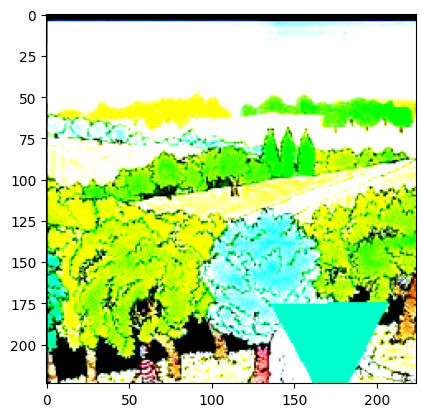

In [4]:
for images, masks, labels in test_dl:
    print(images.shape, masks.shape, labels)
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    break

In [ ]:
from metrics import calculate_metrics, ROC_AUC, RoadCombined, Sensitivity
from results import ResultMetrics
from utils import ERFUpsamplingFast, _GradCAMPlusPlus, _DeepLiftShap, ERFUpsampling, SimpleUpsampling

results = ResultMetrics("./results.csv")

for layer in model.features[15:]:
    # for attribution in [_GradCAMPlusPlus(model, layer), _DeepLiftShap()]:
    for attribution in [_GradCAMPlusPlus(model, layer), _DeepLiftShap()]:
        # for upsample in [ERFUpsamplingFast(model, layer, device), ERFUpsampling(model, layer, device), SimpleUpsampling((224,224)) ]:   
        for upsample in [ERFUpsamplingFast(model, layer, device), ERFUpsampling(model, layer, device)]:   
            calculate_metrics(model=model,
                            attribute_method=attribution,
                            test_dl=test_dl,
                            train_dl=train_dl,
                            layers=[layer],
                            metrics=[ROC_AUC()],
                            result_metrics=results,
                            upsample=upsample,
                            device=device,
                            model_name="VGG11",
                            contains_mask=True)
        